In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=72675ddb6ac3d304deddb51933d3c13b0bac839b2fc1e92a947bb7d0049ce9be
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 16.0 GB  | Proc size: 163.5 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import gc
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms,datasets,models
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import datetime
from PIL import Image
import warnings
from tqdm.notebook import tqdm
import random

In [3]:
warnings.simplefilter('ignore')
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)
torch.cuda.manual_seed(7)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Data frame 

In [5]:
path = '../input/pothole-detection-dataset/normal'
image_path=[]
target=[]
for i in os.listdir(path):
    image_path.append(os.path.join(path,i))
    target.append(0)
path = '../input/pothole-detection-dataset/potholes'
for i in os.listdir(path):
    image_path.append(os.path.join(path,i))
    target.append(1)

In [6]:
table = {'image_path': image_path, 'target': target}
df = pd.DataFrame(data=table)
df = df.sample(frac = 1).reset_index(drop=True) 
df = df.drop([29]).reset_index(drop=True)

In [7]:
df.head(10)

,image_path,target
0,../input/pothole-detection-dataset/normal/196.jpg,0
1,../input/pothole-detection-dataset/potholes/27...,1
2,../input/pothole-detection-dataset/normal/65.jpg,0
3,../input/pothole-detection-dataset/normal/149.jpg,0
4,../input/pothole-detection-dataset/normal/225.jpg,0
5,../input/pothole-detection-dataset/potholes/25...,1
6,../input/pothole-detection-dataset/normal/250.jpg,0
7,../input/pothole-detection-dataset/normal/328.jpg,0
8,../input/pothole-detection-dataset/potholes/94...,1
9,../input/pothole-detection-dataset/normal/86.jpg,0


#### EDA

Text(0, 0.5, 'samples')

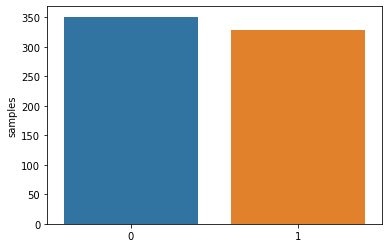

In [8]:
x=df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [9]:
train_length = int(df.shape[0]*0.7)
train_df = df.iloc[:train_length].reset_index(drop=True)
test_df = df.iloc[train_length:].reset_index(drop=True)

##### Trainig data Info

Text(0, 0.5, 'samples')

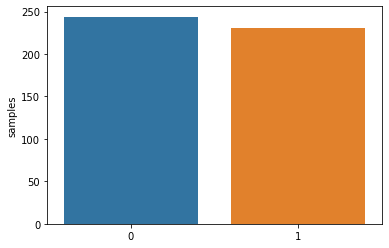

In [10]:
x=train_df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

##### Test data info

Text(0, 0.5, 'samples')

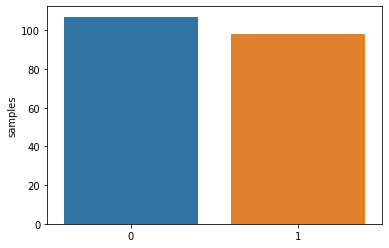

In [11]:
x=test_df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [12]:
class CustomDataset(Dataset):
    def __init__(self,dataframe,transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self,index):
        image = self.dataframe.iloc[index]['image_path']
        image = cv2.imread(image)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[index]["target"]
        return {"image": torch.tensor(image, dtype=torch.float), "targets": torch.tensor(label, dtype = torch.long)}

In [13]:
def get_model(classes=2):
    model = models.resnet34(pretrained=True)
    features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.BatchNorm1d(features),
        nn.Dropout(p=0.25),
        nn.Linear(in_features = features, out_features = 2048),
        nn.ReLU(),
        nn.BatchNorm1d(2048),
        nn.Dropout(p=0.5),
        nn.Linear(in_features = 2048, out_features = classes)
    )
    return model

In [14]:
model = get_model()
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [16]:
optimizer  = optim.Adam(model.parameters(),lr = 0.00003)
loss_function = nn.CrossEntropyLoss()
train_dataset = CustomDataset(
dataframe=train_df,
transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 4)
valid_dataset = CustomDataset(
dataframe=test_df,
transform=test_transform)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [17]:
for epochs in tqdm(range(10),desc="Epochs"):
    model.train()
    for data_in_model in tqdm(train_loader, desc="Training"):
        inputs = data_in_model['image']
        target = data_in_model['targets'] 
        
        inputs = inputs.to(device, dtype = torch.float)
        targets = target.to(device, dtype = torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs,targets)
        loss.backward()
        optimizer.step()
        
    model.eval()
    final_targets = []
    final_outputs = []
    val_loss = 0
    with torch.no_grad():
        for data_in_model in tqdm(valid_loader, desc="Evaluating"):
            inputs = data_in_model['image']
            targets = data_in_model['targets']

            inputs = inputs.to(device, dtype = torch.float)
            targets = targets.to(device, dtype = torch.long)

            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss
            _,predictions = torch.max(outputs, 1)

            targets = targets.detach().cpu().numpy().tolist()
            predictions = predictions.detach().cpu().numpy().tolist()

            final_targets.extend(targets)
            final_outputs.extend(predictions)
    PREDS = np.array(final_outputs)
    TARGETS = np.array(final_targets)
    acc = (PREDS == TARGETS).mean() * 100
    print("EPOCH: {}/10".format(epochs+1))
    print("ACCURACY---------------------------------------------------->{}".format(acc))
    print("LOSS-------------------------------------------------------->{}".format(val_loss))

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 1/10
ACCURACY---------------------------------------------------->96.09756097560975
LOSS-------------------------------------------------------->1.8982996940612793


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 2/10
ACCURACY---------------------------------------------------->96.58536585365853
LOSS-------------------------------------------------------->1.203516960144043


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 3/10
ACCURACY---------------------------------------------------->96.58536585365853
LOSS-------------------------------------------------------->1.205437421798706


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 4/10
ACCURACY---------------------------------------------------->97.07317073170731
LOSS-------------------------------------------------------->0.9973646998405457


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 5/10
ACCURACY---------------------------------------------------->98.04878048780488
LOSS-------------------------------------------------------->0.951337993144989


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 6/10
ACCURACY---------------------------------------------------->96.58536585365853
LOSS-------------------------------------------------------->1.0956693887710571


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 7/10
ACCURACY---------------------------------------------------->97.07317073170731
LOSS-------------------------------------------------------->1.0790667533874512


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 8/10
ACCURACY---------------------------------------------------->97.07317073170731
LOSS-------------------------------------------------------->1.007262110710144


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 9/10
ACCURACY---------------------------------------------------->97.07317073170731
LOSS-------------------------------------------------------->1.1791222095489502


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

EPOCH: 10/10
ACCURACY---------------------------------------------------->97.07317073170731
LOSS-------------------------------------------------------->1.1636159420013428
